<a href="https://colab.research.google.com/github/elibtronic/2025_state_of_scholarly_communication/blob/main/2025_SofSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 2025 State of Scholarly Communication

Uses OpenAlex data based on pub year and ROR on record
Augmented with Policy Finder Data



In [ ]:
import requests
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import seaborn as sns
from datetime import datetime
from google.colab import files

#Set graph colors
colors = sns.color_palette('inferno_r')
color = sns.color_palette('inferno_r')[0]


# @markdown ## OpenAlex Settings

mailto = "tribaric@brocku.ca"  # @param {type:"string"}

# @markdown We'll search on both ROR and Open Alex Insitutional ID
ror_id     = "056am2717"  # @param {type:"string"}

from_publication_date = "2024-07-01"  # @param {type:"date"}
to_publication_date = "2025-06-30"  # @param {type:"date"}

# @markdown ## Policy Finder API Settings

pf_key = "" # @param {"type":"string"}

#just ror formulation
filter = f"authorships.institutions.ror:{ror_id},from_publication_date:{from_publication_date},to_publication_date:{to_publication_date},type:article,primary_location.source.type:journal"

api_url = f"https://api.openalex.org/works?filter={filter}&per-page=200&mailto={mailto}"

cursor = "*"  # Cursor for the first request
works = []  # List to accumulate all results

while cursor:
    # Construct the request URL with the current cursor
    request_url = api_url + f"&cursor={cursor}"

    # Get results from the API
    page = requests.get(request_url).json()
    results = page.get('results')
    meta = page.get('meta')

    # Accumulate results
    works += results

    # Get the next cursor from the current results
    cursor = meta.get('next_cursor')

    # Print progress
    total = int(meta.get("count"))
    #print(f"\r{len(works)}/{total}: {request_url}", end="")

# Do something with all results
print(f"\nTotal works: {len(works)}")


Total works: 682


## Open Alex Data Fetch

Extracts
- ORCID of first Brock Author (assuming this is the most important author)
- author postion
- ORCID of corresponding author or 'none' if not CA is listed
- Publication Date
- DOI of piece
- Item already Open Access?
- ISSN of piece
- source of item
- publisher of item

Still to do


In [ ]:
orcid_list = []
author_pos_list = []
corresponding_author_list = []
pub_date_list = []
doi_list = []
issn_list = []
already_oa_list = []
oa_status_list = []
source_list = []
publisher_list = []


for work in works:
  doi_list.append(work['doi'])

  orcid = ""
  for author in work['authorships']:

    for intst in author['institutions']:
      if (intst['ror'] == "https://ror.org/"+ror_id) and orcid == "":
        orcid = author['author']['orcid']
        author_pos = author['author_position']
        break
  author_pos_list.append(author_pos)
  orcid_list.append(orcid)

  #Has at least one corresponding author and write it in if true
  corresponding_author = ""
  for author in work['authorships']:
    if author['is_corresponding'] == True:
      corresponding_author = author['author']['orcid']

  if corresponding_author == "":
    corresponding_author = "none"

  corresponding_author_list.append(corresponding_author)

  try:
    issn = work['primary_location']['source']['issn'][0]
  except:
    issn = ""
  issn_list.append(issn)

  try:
    pub_date = work['publication_date']
  except:
    pub_date = ""
  pub_date_list.append(pub_date)

  if work['open_access']['is_oa'] == True:
    already_oa = "yes"
  else:
    already_oa = "no"
  already_oa_list.append(already_oa)

  try:
    oa_status = work['open_access']['oa_status']
  except:
    oa_status = ""
  oa_status_list.append(oa_status)

  try:
    source = work['primary_location']['source']['display_name']
  except:
    source = ""
  source_list.append(source)

  try:
    publisher = work['primary_location']['source']['host_organization_name']
  except:
    publisher = ""
  publisher_list.append(publisher)


  df = pd.DataFrame(list(zip(orcid_list, author_pos_list, corresponding_author_list, pub_date_list,doi_list,already_oa_list,oa_status_list,issn_list,source_list,publisher_list)), columns =['ORCID','author_position','corresponding_author','pub_date','DOI','already_oa','oa_status','issn','source','publisher'])

In [ ]:
#df.sample(10)

## Policy Finder

Grabs associated Policy Finder policy for ISSN of DOI

In [ ]:
#As there is no Python wrapper for this API, I'll make a function
#that will use requests to grab the JSON
def pf_fetch(pf_key,issn):
  '''Returns JSON from Policy Finder given an ISSN and API Key'''
  paip_options = {
      "item-type" : "publication",
      "api-key" : pf_key,
      "format" : "Json",
  }

  paip_options['identifier'] = issn

  requests.packages.urllib3.disable_warnings()
  api_blob = requests.get("https://v2.sherpa.ac.uk/cgi/retrieve_by_id",params=paip_options,verify=False).json()

  if api_blob['items'] == []:
    return None
  else:
    return api_blob['items'][0]

In [ ]:
list_uri = []
list_submitted_oa_policy = []
list_accepted_oa_policy = []
list_published_oa_policy = []
prog = 0

print("Retrieving PolicyFinder data for ", len(df), " DOIs")

for key, value in df.iterrows():

  #some low-fi progress feedback
  prog += 1
  if prog % 50 == 0:
    print(str(prog)+"..", end = "")
  if prog % 500 == 0:
    print("\n")

  if value['issn'] == "":
    #print("no issn")
    list_uri.append("None")
    list_submitted_oa_policy.append("None")
    list_accepted_oa_policy.append("None")
    list_published_oa_policy.append("None")
  else:
    #print(value['issn'])
    par = pf_fetch(pf_key,value['issn'])

    #No policy found in otherwords
    if par == None:
      list_uri.append("None")
      list_submitted_oa_policy.append("None")
      list_accepted_oa_policy.append("None")
      list_published_oa_policy.append("None")
    else:
      policy_uri = par['system_metadata']['uri']
      accepted_oa_policy = ""
      published_oa_policy = ""
      submitted_oa_policy = ""
      for pub_policy in par['publisher_policy']:
        for per_oa in pub_policy['permitted_oa']:
          try:
            #Only keep ones that have IR as option, for first pass
            if 'institutional_repository' in per_oa['location']['location']:
              #accepted policy first
              if per_oa['article_version'][0] == 'accepted':
                try:
                  conditions_text = " ".join(per_oa['conditions'])
                except:
                  conditions_text = "no conditions"
                if per_oa['additional_oa_fee'] == "no":
                  fee_text = "fee_no"
                else:
                  fee_text = "fee_yes"
                per_id = str(per_oa['id'])
                accepted_oa_policy += per_id+":"+fee_text+":"+conditions_text+";"

              #published
              elif per_oa['article_version'][0] == 'published':
                try:
                  conditions_text = " ".join(per_oa['conditions'])
                except:
                  conditions_text = "no conditions"
                if per_oa['additional_oa_fee'] == "no":
                  fee_text = "fee_no"
                else:
                  fee_text = "fee_yes"
                per_id = str(per_oa['id']).strip()
                published_oa_policy += per_id+":"+fee_text+":"+conditions_text+";"

              #submitted
              elif per_oa['article_version'][0] == 'submitted':
                try:
                  conditions_text = " ".join(per_oa['conditions'])
                except:
                  conditions_text = "no conditions"
                if per_oa['additional_oa_fee'] == "no":
                  fee_text = "fee_no"
                else:
                  fee_text = "fee_yes"
                per_id = str(per_oa['id']).strip()
                submitted_oa_policy += per_id+":"+fee_text+":"+conditions_text+";"
          except: #on occasion it error out totally
            #print("error")
            policy_uri = "error"
            accepted_oa_policy = "error"
            published_oa_policy = "error"
            submitted_oa_policy = "error"

        if submitted_oa_policy == "":
          submitted_oa_policy = "None"
        if accepted_oa_policy == "":
          accepted_oa_policy = "None"
        if published_oa_policy == "":
          published_oa_policy = "None"

      #print("\n")
      #print(policy_uri)
      list_uri.append(policy_uri)
      #print(submitted_oa_policy)
      list_submitted_oa_policy.append(submitted_oa_policy)
      #print(accepted_oa_policy)
      list_accepted_oa_policy.append(accepted_oa_policy)
      #print(published_oa_policy)
      list_published_oa_policy.append(published_oa_policy)

# add these new columns to the df
df['policy_uri'] = list_uri
df['submitted_oa_policy'] = list_submitted_oa_policy
df['accepted_oa_policy'] = list_accepted_oa_policy
df['published_oa_policy'] = list_published_oa_policy

print("\nDone retrieving PolicyFinder data.")

Retrieving PolicyFinder data for  682  DOIs
50..100..150..200..250..300..350..400..450..500..

550..600..650..
Done retrieving PolicyFinder data.


In [ ]:
df.sample(10)

,ORCID,author_position,corresponding_author,pub_date,DOI,already_oa,oa_status,issn,source,publisher,policy_uri,submitted_oa_policy,accepted_oa_policy,published_oa_policy
481,None,first,None,2024-12-01,https://doi.org/10.1111/1911-3838.12383,yes,hybrid,1911-382X,Accounting Perspectives,Wiley,https://v2.sherpa.ac.uk/id/publication/4642,None,1866:fee_no:Published source must be acknowled...,None
618,https://orcid.org/0000-0003-2909-8286,middle,none,2025-05-22,https://doi.org/10.1080/00918369.2025.2507889,no,closed,0091-8369,Journal of Homosexuality,Taylor & Francis,https://v2.sherpa.ac.uk/id/publication/18959,None,None,None
441,https://orcid.org/0000-0002-8317-3497,middle,None,2024-10-16,https://doi.org/10.2989/16073606.2024.2411461,no,closed,1607-3606,Quaestiones Mathematicae,Taylor & Francis,https://v2.sherpa.ac.uk/id/publication/305,None,None,None
205,https://orcid.org/0000-0002-9390-314X,first,https://orcid.org/0000-0002-9390-314X,2024-07-30,https://doi.org/10.1111/pere.12567,yes,hybrid,1350-4126,Personal Relationships,Wiley,https://v2.sherpa.ac.uk/id/publication/16013,11204:fee_no:Must acknowledge acceptance for p...,None,None
299,https://orcid.org/0000-0003-2833-2501,middle,none,2025-03-06,https://doi.org/10.1016/j.envres.2025.121330,no,closed,0013-9351,Environmental Research,Elsevier BV,https://v2.sherpa.ac.uk/id/publication/11285,None,11157:fee_no:Must link to publisher version wi...,11159:fee_yes:Published source must be acknowl...
267,https://orcid.org/0000-0002-9322-0410,first,https://orcid.org/0000-0003-4046-7994,2024-12-16,https://doi.org/10.1080/10618600.2024.2441988,no,closed,1061-8600,Journal of Computational and Graphical Statistics,Taylor & Francis,https://v2.sherpa.ac.uk/id/publication/817,None,None,None
344,https://orcid.org/0000-0002-5214-1943,middle,none,2025-06-12,https://doi.org/10.1007/s11136-025-04001-1,no,closed,0962-9343,Quality of Life Research,Springer Science+Business Media,https://v2.sherpa.ac.uk/id/publication/16631,None,None,None
84,https://orcid.org/0000-0003-2626-1375,middle,none,2025-06-19,https://doi.org/10.1021/acs.joc.5c00819,no,closed,0022-3263,The Journal of Organic Chemistry,American Chemical Society,https://v2.sherpa.ac.uk/id/publication/7797,None,None,710:fee_yes:no conditions;
96,https://orcid.org/0000-0002-7336-8901,first,https://orcid.org/0000-0002-8749-9486,2024-11-07,https://doi.org/10.3390/agronomy14112623,yes,gold,2073-4395,Agronomy,Multidisciplinary Digital Publishing Institute,https://v2.sherpa.ac.uk/id/publication/19453,None,None,None
602,https://orcid.org/0000-0002-3581-6312,first,none,2025-05-02,https://doi.org/10.1079/hai.2025.0015,yes,diamond,2957-9538,Human-Animal Interactions,CAB International Publishing,https://v2.sherpa.ac.uk/id/publication/42804,None,None,None


# Analysis

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

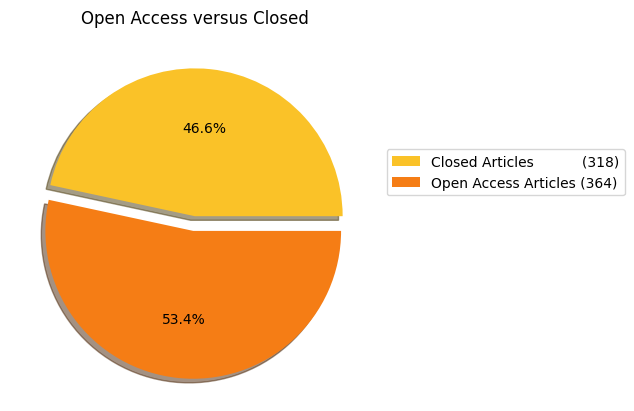

In [ ]:
#Total Versus OA as pie

not_oa = df['already_oa'].value_counts()['no']
oa = df['already_oa'].value_counts()['yes']
explode = (0, 0.1)
legend = ["Closed Articles           ("+str(not_oa)+")","Open Access Articles ("+str(oa)+")"]

plt.pie([not_oa,oa],autopct="%1.1f%%",explode=explode,shadow=True,startangle=0,colors=colors)
plt.legend(legend,bbox_to_anchor=(1.0,0.7))
plt.title("Open Access versus Closed")

figname = "Open_Access_versus_Closed.png"
plt.savefig(figname, bbox_inches='tight')
files.download(figname)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

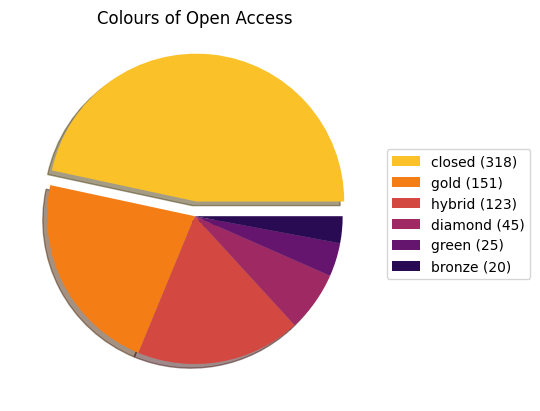

In [ ]:
#colors of OA as pie

oa_colors = df['oa_status'].value_counts().values
legend = df['oa_status'].value_counts().index
legend = ['%s (%1d)' % (l, s) for l, s in zip(df['oa_status'].value_counts().index, df['oa_status'].value_counts().values)]

explode = list((0.0,) * len(df['oa_status'].value_counts().index))
explode[0] = 0.1
explode = tuple(explode)


plt.pie(oa_colors,shadow=True, explode=explode, startangle=0,colors=colors)
plt.legend(legend,bbox_to_anchor=(1.0,0.7))
plt.title("Colours of Open Access")

figname = "Colours_of_Open_Access.png"
plt.savefig(figname, bbox_inches='tight')
files.download(figname)

plt.show()



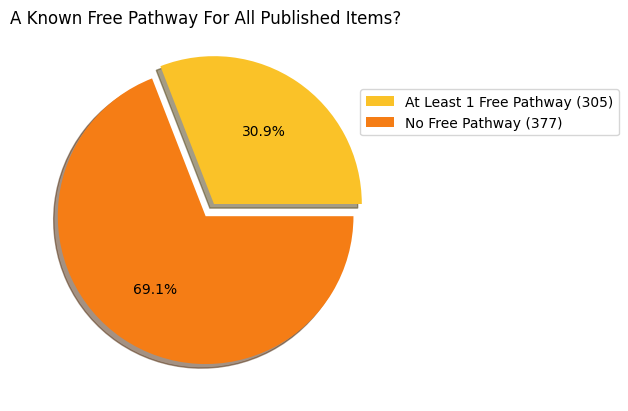

In [ ]:
#Articles with at least 1 free pathway

least_one_free_pathway = len(df[df['submitted_oa_policy'].str.contains('fee_no', case=False) \
                                | df['accepted_oa_policy'].str.contains('fee_no', case=False) \
                                | df['published_oa_policy'].str.contains('fee_no', case=False)])
total = len(df)

legend = ["At Least 1 Free Pathway ("+str(least_one_free_pathway)+")","No Free Pathway ("+str(total-least_one_free_pathway)+")"]
explode = (0.1, 0.0)
plt.pie([least_one_free_pathway,total],autopct="%1.1f%%",explode=explode,shadow=True,startangle=0,colors=colors)
plt.legend(legend,bbox_to_anchor=(0.9,0.7))
plt.title("A Known Free Pathway For All Published Items?")

figname = "One_Free_Pathway.png"
plt.savefig(figname, bbox_inches='tight')
#files.download(figname)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

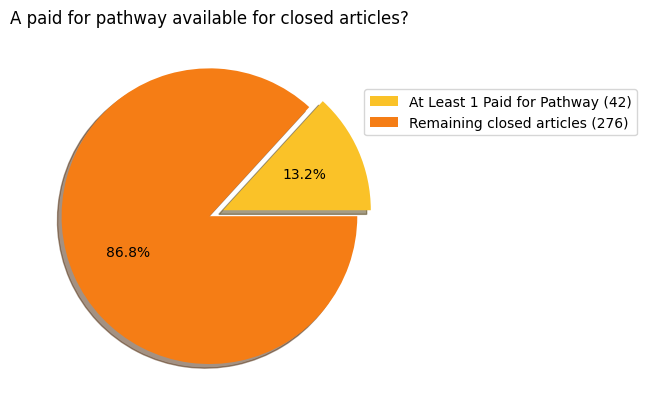

In [ ]:
#For close articles, free, paid for other pathway
closed_articles = df[df['already_oa'] == 'no']

least_one_paid_pathway = len(closed_articles[closed_articles['submitted_oa_policy'].str.contains('fee_yes', case=False) \
                                | closed_articles['accepted_oa_policy'].str.contains('fee_yes', case=False) \
                                | closed_articles['published_oa_policy'].str.contains('fee_yes', case=False)])

total_remaining_closed = len(closed_articles) - least_one_paid_pathway

legend = ["At Least 1 Paid for Pathway ("+str(least_one_paid_pathway)+")","Remaining closed articles ("+str(total_remaining_closed)+")"]
explode = (0.1, 0.0)
plt.pie([least_one_paid_pathway,total_remaining_closed],autopct="%1.1f%%",explode=explode,shadow=True,startangle=0,colors=colors)
plt.legend(legend,bbox_to_anchor=(0.9,0.7))
plt.title("A paid for pathway available for closed articles?")

figname = "Paid_For_Option_Closed_Articles.png"
plt.savefig(figname, bbox_inches='tight')
files.download(figname)
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

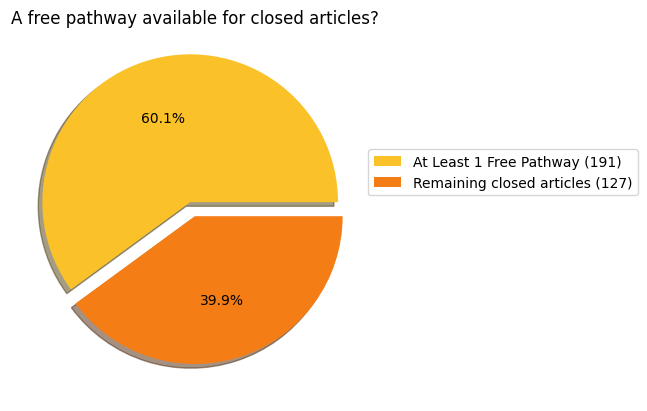

In [ ]:
#at least one free pathway for closed articles
closed_articles = df[df['already_oa'] == 'no']

least_one_free_pathway = len(closed_articles[closed_articles['submitted_oa_policy'].str.contains('fee_no', case=False) \
                                | closed_articles['accepted_oa_policy'].str.contains('fee_no', case=False) \
                                | closed_articles['published_oa_policy'].str.contains('fee_no', case=False)])

total_remaining_closed = len(closed_articles) - least_one_free_pathway


legend = ["At Least 1 Free Pathway ("+str(least_one_free_pathway)+")","Remaining closed articles ("+str(total_remaining_closed)+")"]
explode = (0.1, 0.0)
plt.pie([least_one_free_pathway,total_remaining_closed],autopct="%1.1f%%",explode=explode,shadow=True,startangle=0,colors=colors)
plt.legend(legend,bbox_to_anchor=(0.95,0.7))
plt.title("A free pathway available for closed articles?")

figname = "Free_Option_Closed_Articles.png"
plt.savefig(figname, bbox_inches='tight')
files.download(figname)
plt.show()


In [ ]:
closed_articles = df[df['already_oa'] == 'no']

least_one_free_pathway = closed_articles[closed_articles['submitted_oa_policy'].str.contains('fee_no', case=False) \
                                | closed_articles['accepted_oa_policy'].str.contains('fee_no', case=False) \
                                | closed_articles['published_oa_policy'].str.contains('fee_no', case=False)]

least_one_free_pathway.head(10)

,ORCID,author_position,corresponding_author,pub_date,DOI,already_oa,oa_status,issn,source,publisher,policy_uri,submitted_oa_policy,accepted_oa_policy,published_oa_policy
6,https://orcid.org/0000-0001-7350-6991,middle,https://orcid.org/0000-0002-3892-4087,2025-03-10,https://doi.org/10.1038/s41593-025-01880-y,no,closed,1097-6256,Nature Neuroscience,Nature Portfolio,https://v2.sherpa.ac.uk/id/publication/1657,11461:fee_no:Must link to publisher version Up...,11462:fee_no:Must link to publisher version Pu...,None
17,None,first,https://orcid.org/0000-0001-5104-4968,2024-07-01,https://doi.org/10.1080/13504622.2024.2365395,no,closed,1350-4622,Environmental Education Research,Taylor & Francis,https://v2.sherpa.ac.uk/id/publication/5223,None,52:fee_no:Published source must be acknowledge...,None
18,https://orcid.org/0000-0002-4989-5058,middle,none,2024-07-23,https://doi.org/10.1093/jnci/djae145,no,closed,0027-8874,JNCI Journal of the National Cancer Institute,Oxford University Press,https://v2.sherpa.ac.uk/id/publication/617,None,39:fee_no:Publisher source must be acknowledge...,None
19,https://orcid.org/0000-0003-0925-611X,first,https://orcid.org/0000-0003-4671-7843,2024-07-30,https://doi.org/10.1038/s44159-024-00341-w,no,closed,2731-0574,Nature Reviews Psychology,Nature Portfolio,https://v2.sherpa.ac.uk/id/publication/46230,8170:fee_no:no conditions;,87:fee_no:Must link to publisher version Publi...,None
28,https://orcid.org/0000-0002-6591-6760,middle,none,2024-12-01,https://doi.org/10.1111/ele.14513,no,closed,1461-023X,Ecology Letters,Wiley,https://v2.sherpa.ac.uk/id/publication/6991,11204:fee_no:Must acknowledge acceptance for p...,None,None
31,https://orcid.org/0000-0003-3523-8126,middle,none,2024-07-15,https://doi.org/10.1109/tnse.2024.3427672,no,closed,2327-4697,IEEE Transactions on Network Science and Engin...,Institute of Electrical and Electronics Engineers,https://v2.sherpa.ac.uk/id/publication/37964,11087:fee_no:Must be replaced with accepted ve...,"11089:fee_no:When accepted for publication, se...",None
41,https://orcid.org/0000-0003-3147-4703,first,none,2024-08-29,https://doi.org/10.1123/pes.2024-0021,no,closed,0899-8493,Pediatric Exercise Science,Human Kinetics,https://v2.sherpa.ac.uk/id/publication/12259,None,3849:fee_no:Publisher copyright and source mus...,None
46,https://orcid.org/0000-0002-7352-4775,last,https://orcid.org/0000-0002-7749-1501,2024-07-09,https://doi.org/10.1080/25742981.2024.2371392,no,closed,2574-2981,Curriculum Studies in Health and Physical Educ...,Taylor & Francis,https://v2.sherpa.ac.uk/id/publication/42019,None,52:fee_no:Published source must be acknowledge...,None
49,https://orcid.org/0000-0003-2126-3160,first,https://orcid.org/0000-0003-2126-3160,2024-08-18,https://doi.org/10.1080/13676261.2024.2392197,no,closed,1367-6261,Journal of Youth Studies,Taylor & Francis,https://v2.sherpa.ac.uk/id/publication/5793,None,52:fee_no:Published source must be acknowledge...,None
50,https://orcid.org/0000-0002-7189-1619,middle,https://orcid.org/0000-0003-0225-1586,2024-08-23,https://doi.org/10.1016/j.jcae.2024.100440,no,closed,1815-5669,Journal of Contemporary Accounting & Economics,Elsevier BV,https://v2.sherpa.ac.uk/id/publication/13834,None,11179:fee_no:Must link to publisher version wi...,11181:fee_yes:Published source must be acknowl...


In [ ]:
#top 10 sources
df.value_counts('source')[0:10]

,count
source,
Physiology,13
Academy of Management Proceedings,9
Journal of Sport Management,9
PLoS ONE,8
Scientific Reports,8
Journal of Sport and Exercise Psychology,6
Education Sciences,6
Leisure/Loisir,5
Innovation in Aging,5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

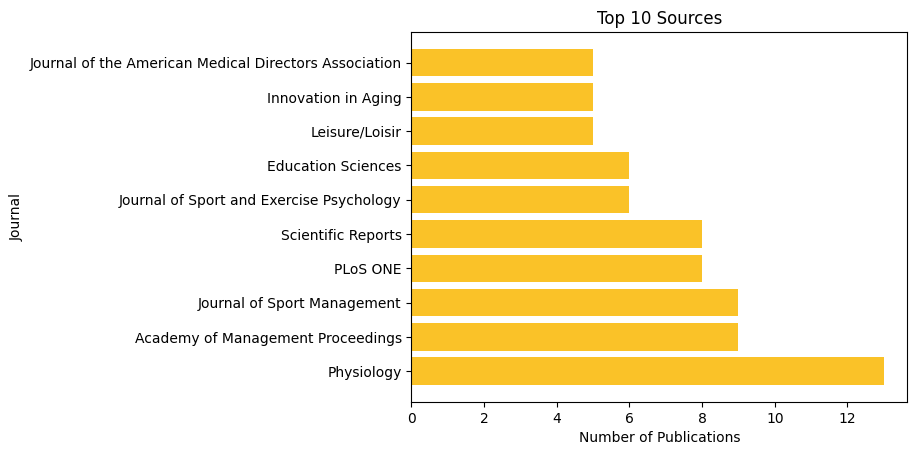

In [ ]:
#Top Sources

plt.barh(df.value_counts('source')[0:10].index,df.value_counts('source')[0:10].T,color=color)
plt.title("Top 10 Sources")
plt.ylabel("Journal")
plt.xlabel("Number of Publications")
figname = "Top_10_Sources.png"
plt.savefig(figname, bbox_inches='tight')
files.download(figname)
plt.show()

In [ ]:
#top 10 publishers
#df.value_counts('publisher')[0:10]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

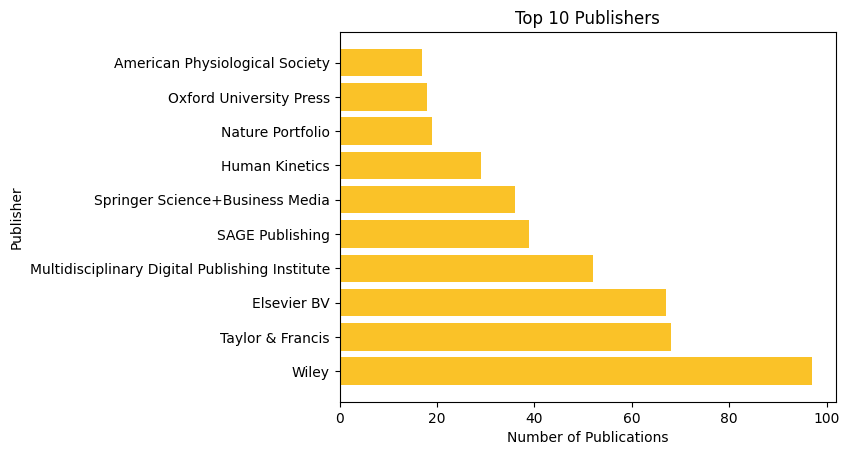

In [ ]:
#top 10 publishers
plt.barh(df.value_counts('publisher')[0:10].index,df.value_counts('publisher')[0:10].T,color=color)
plt.title("Top 10 Publishers")
plt.ylabel("Publisher")
plt.xlabel("Number of Publications")
figname = "Top_10_Publishers.png"
plt.savefig(figname, bbox_inches='tight')
files.download(figname)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

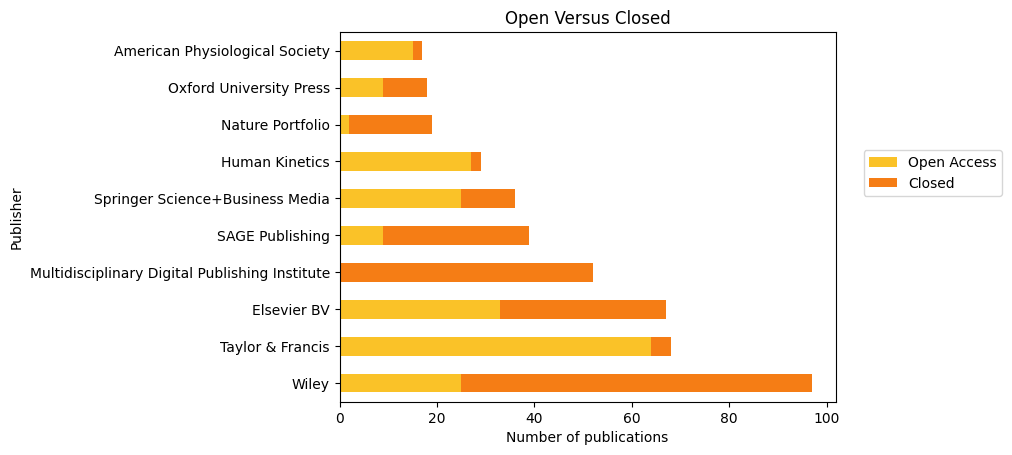

In [ ]:
#Closed or Open by publisher?

top_10_pub_list = list(df.value_counts('publisher')[0:10].index)

df_top_pub = df[df['publisher'].isin(top_10_pub_list)]
df_top_pub = df_top_pub.groupby('publisher')['already_oa'].value_counts()
df_top_pub = df_top_pub.unstack().fillna(0)

total_pubs = []
for pub in df_top_pub.iterrows():
  total_pubs.append(pub[1]['no']+pub[1]['yes'])
df_top_pub['total'] = total_pubs
df_top_pub.sort_values(by='total',ascending=False,inplace=True)
del(df_top_pub['total'])

df_top_pub.plot(kind='barh',stacked=True,color=colors,title="Proportion of Open Access",xlabel='Number of publications')
plt.legend(["Open Access","Closed"],bbox_to_anchor=(1.35,0.7))
plt.ylabel("Publisher")
plt.title("Open Versus Closed")
figname = "Proportion_of_Open_Access.png"
plt.savefig(figname, bbox_inches='tight')
files.download(figname)
plt.show()

#Samples from Data set

In [ ]:
#Just a sample of what we have
#df.sample(10)

# Write out to File

In [ ]:
#DOI data as CSV


csv_file_name = "Brock_OpenAlex_Harvest_Start_Date_"+from_publication_date+"_to_"+to_publication_date+"_retrieved_"+datetime.today().strftime('%Y-%m-%d')+".csv"
print("Saving to file: "+csv_file_name)
df.to_csv(csv_file_name,index=False)
files.download(csv_file_name)